# Basic Model

### Xray Generation


X-rays are a type of electromagnetic radiation that is used in projection radiography. X-rays are generated in x-ray tubes, an example of which is shown below. 

![image.png](https://prod-images-static.radiopaedia.org/images/3165401/7ef2c07bd518defc594a4328dbfd2b_jumbo.jpg)

The formation of an x-ray begins with the generation of current within a thin tungsten wire that is contained within the cathode. Resistance within the wire to this current causes the wire to heat up and emit electrons. These electrons are focused onto the anode by applying an anode voltage and this creates a current from the cathode to the anode. 
The process causes electrons to accelerate towards the anode. When the electrons strike the anode they produce special interactions which result in characteristic and bremsstrahlung x-rays. These x-rays are then emitted from the tube.   

### Load Python Modules

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import cv2
import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from pathlib import Path
import skimage
from skimage.transform import resize

### Load Data

The information on this dataset can be found at:
http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5



In [2]:
# Folder paths
normal_train_folder = '/content/drive/MyDrive/chest_xray/train/NORMAL'
pneumonia_train_folder = '/content/drive/MyDrive/chest_xray/train/PNEUMONIA'

normal_val_folder = '/content/drive/MyDrive/chest_xray/val/NORMAL'
pneumonia_val_folder = '/content/drive/MyDrive/chest_xray/val/PNEUMONIA'

normal_test_folder = '/content/drive/MyDrive/chest_xray/test/NORMAL'
pneumonia_test_folder = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA'

In [3]:
# Break into data and labels
train_data = []
train_labels = []

# Get the normal training images
for file in tqdm.tqdm(os.listdir(normal_train_folder)):
  image = cv2.imread(normal_train_folder + '/' + file)
  image = resize(image, (200,200,3))
  image = np.asarray(image)
  if image is not None:
      train_data.append(image)
      train_labels.append(0)

# Get the pneumonia training images
for file in tqdm.tqdm(os.listdir(pneumonia_train_folder)):
  image = cv2.imread(pneumonia_train_folder + '/' + file)
  image = resize(image,(200,200,3))
  image = np.asarray(image)
  if image is not None:
      train_data.append(image)
      train_labels.append(1)

# Shuffle the data
x_train, y_train = shuffle(train_data, train_labels)

100%|██████████| 3875/3875 [09:07<00:00,  7.08it/s]


In [4]:
x_train[0].size

120000

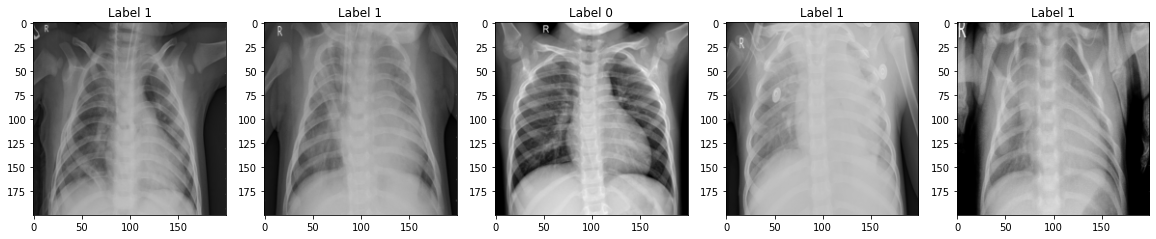

In [5]:
# Display sample images
plt.figure(figsize=(20,20))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(x_train[i])
  plt.title(f'Label {y_train[i]}')
plt.show()

In [6]:
# Break into data and labels
val_data = []
val_labels = []

# Get the normal training images
for file in tqdm.tqdm(os.listdir(normal_val_folder)):
  image = cv2.imread(normal_val_folder + '/' + file)
  image = resize(image, (200,200,3))
  image = np.asarray(image)
  if image is not None:
    val_data.append(image)
    val_labels.append(0)

# Get the pneumonia training images
for file in tqdm.tqdm(os.listdir(pneumonia_val_folder)):
  image = cv2.imread(pneumonia_val_folder + '/' + file)
  image = resize(image,(200,200,3))
  image = np.asarray(image)
  if image is not None:
    val_data.append(image)
    val_labels.append(1)

# Shuffle the data
x_val, y_val = shuffle(val_data, val_labels)

100%|██████████| 8/8 [00:00<00:00,  8.34it/s]


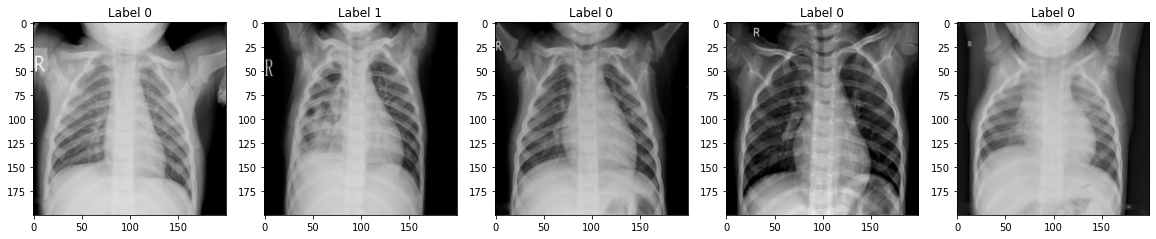

In [7]:
# Display sample images
plt.figure(figsize=(20,20))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(x_val[i])
  plt.title(f'Label {y_val[i]}')
plt.show()

In [8]:
# Break into data and labels
test_data = []
test_labels = []

# Get the normal training images
for file in tqdm.tqdm(os.listdir(normal_test_folder)):
  image = cv2.imread(normal_test_folder + '/' + file)
  image = resize(image, (200,200,3))
  image = np.asarray(image)
  if image is not None:
    test_data.append(image)
    test_labels.append(0)

# Get the pneumonia training images
for file in tqdm.tqdm(os.listdir(pneumonia_test_folder)):
  image = cv2.imread(pneumonia_test_folder + '/' + file)
  image = resize(image,(200,200,3))
  image = np.asarray(image)
  if image is not None:
    test_data.append(image)
    test_labels.append(1)

# Shuffle the data
x_test, y_test = shuffle(test_data, test_labels)

100%|██████████| 390/390 [00:44<00:00,  8.73it/s]


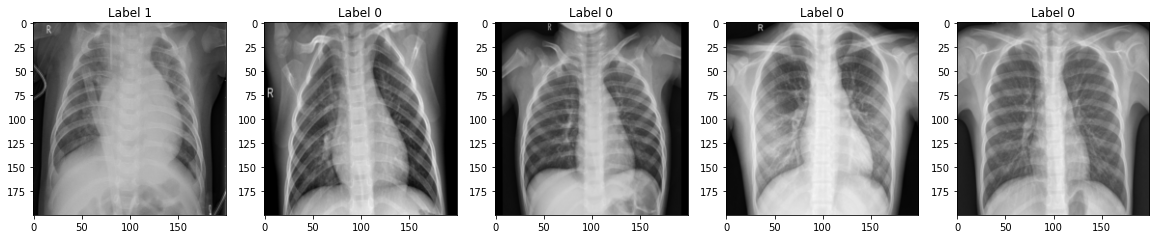

In [9]:
# Display sample images
plt.figure(figsize=(20,20))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(x_test[i])
  plt.title(f'Label {y_test[i]}')
plt.show()

In [10]:
x_train = tf.cast(x_train, tf.float32)
y_train = tf.cast(y_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
y_test = tf.cast(y_test, tf.float32)

In [11]:
# Create input pipeline for the Gradient tape model
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

### Define a sequential model

In [27]:
# Define a sequential model
model = tf.keras.models.Sequential([    
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [28]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
fit = model.fit(x=x_train, y=y_train,epochs=12,validation_data=(x_test,y_test))

Epoch 1/12
163/163 [==============================] - 4s 24ms/step - loss: 0.2601 - accuracy: 0.8901 - val_loss: 1.2399 - val_accuracy: 0.7147
Epoch 2/12
163/163 [==============================] - 4s 23ms/step - loss: 0.1119 - accuracy: 0.9605 - val_loss: 0.5686 - val_accuracy: 0.8029
Epoch 3/12
163/163 [==============================] - 4s 23ms/step - loss: 0.0752 - accuracy: 0.9705 - val_loss: 1.3245 - val_accuracy: 0.7500
Epoch 4/12
163/163 [==============================] - 4s 23ms/step - loss: 0.0478 - accuracy: 0.9829 - val_loss: 1.3028 - val_accuracy: 0.7356
Epoch 5/12
163/163 [==============================] - 4s 23ms/step - loss: 0.0330 - accuracy: 0.9877 - val_loss: 2.2173 - val_accuracy: 0.7260
Epoch 6/12
163/163 [==============================] - 4s 23ms/step - loss: 0.0609 - accuracy: 0.9774 - val_loss: 1.8541 - val_accuracy: 0.7260
Epoch 7/12
163/163 [==============================] - 4s 23ms/step - loss: 0.0208 - accuracy: 0.9927 - val_loss: 2.2952 - val_accuracy: 0.7131

In [16]:
print(fit.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


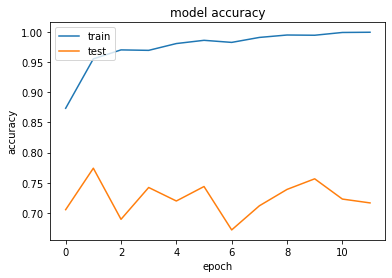

In [17]:
# Summarize the accuracy history
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

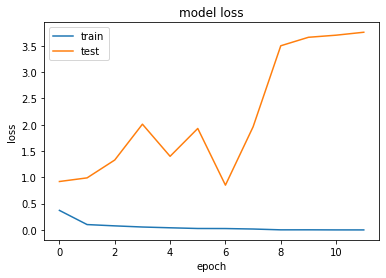

In [23]:
# Summarize the loss history
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Add Compton Scatter to the data

In [39]:
def add_compton_scatter(images, std):
  ans = []
  x = 0
  for im in images:
    im += tf.random.normal(shape=(200,200,3), mean=0.0, stddev=std)
    ans.append(im)
    print(x)
    x += 1
  return tf.cast(ans, tf.float32)

In [ ]:
# Noise of 0.1
x_train_cs_01 = add_compton_scatter(x_train, 0.1) 
x_test_cs_01 = add_compton_scatter(x_test, 0.1)
# Noise of 0.2
x_train_cs_02 = add_compton_scatter(x_train, 0.2) 
x_test_cs_02 = add_compton_scatter(x_test, 0.2)

In [33]:
len(x_train_cs_01)

5216

In [34]:
len(x_train)

5216

In [37]:
x_train.shape

TensorShape([5216, 200, 200, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


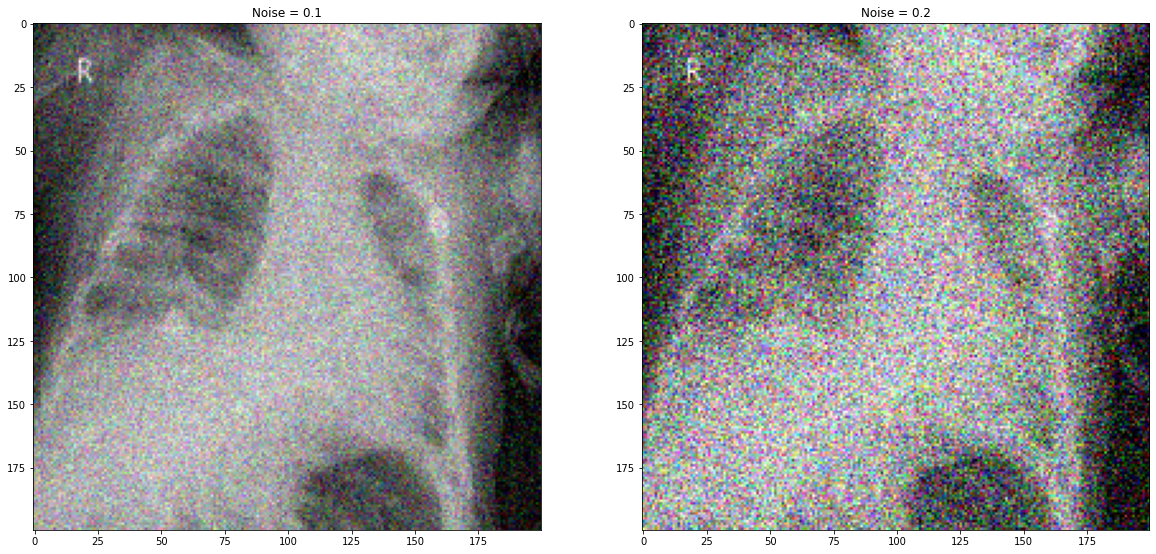

In [41]:
# Display sample images
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(x_train_cs_01[0])
plt.title(f'Noise = 0.1')
plt.subplot(1,2,2)
plt.imshow(x_train_cs_02[0])
plt.title(f'Noise = 0.2')
plt.show()

In [42]:
# Define a sequential model
model = tf.keras.models.Sequential([    
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # length-8 output for classification
])

In [43]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
fit_cs_01 = model.fit(x=x_train_cs_01, y=y_train, epochs=12, validation_data=(x_test_cs_01, y_test))

Epoch 1/12
163/163 [==============================] - 4s 25ms/step - loss: 0.4449 - accuracy: 0.8129 - val_loss: 0.5192 - val_accuracy: 0.7308
Epoch 2/12
163/163 [==============================] - 4s 24ms/step - loss: 0.2771 - accuracy: 0.9116 - val_loss: 1.3395 - val_accuracy: 0.6923
Epoch 3/12
163/163 [==============================] - 4s 24ms/step - loss: 0.2159 - accuracy: 0.9277 - val_loss: 1.1486 - val_accuracy: 0.7484
Epoch 4/12
163/163 [==============================] - 4s 24ms/step - loss: 0.1862 - accuracy: 0.9400 - val_loss: 0.8446 - val_accuracy: 0.7692
Epoch 5/12
163/163 [==============================] - 4s 23ms/step - loss: 0.1688 - accuracy: 0.9519 - val_loss: 0.9464 - val_accuracy: 0.7708
Epoch 6/12
163/163 [==============================] - 4s 23ms/step - loss: 0.1499 - accuracy: 0.9544 - val_loss: 1.4754 - val_accuracy: 0.7596
Epoch 7/12
163/163 [==============================] - 4s 23ms/step - loss: 0.1287 - accuracy: 0.9640 - val_loss: 1.4337 - val_accuracy: 0.7580

In [49]:
# Define a sequential model
model = tf.keras.models.Sequential([    
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # length-8 output for classification
])

In [50]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
fit_cs_02 = model.fit(x=x_train_cs_02, y=y_train,epochs=12,validation_data=(x_test_cs_02,y_test))

Epoch 1/12
163/163 [==============================] - 4s 24ms/step - loss: 0.3771 - accuracy: 0.8579 - val_loss: 0.5006 - val_accuracy: 0.7821
Epoch 2/12
163/163 [==============================] - 4s 23ms/step - loss: 0.1752 - accuracy: 0.9333 - val_loss: 0.8475 - val_accuracy: 0.7228
Epoch 3/12
163/163 [==============================] - 4s 23ms/step - loss: 0.1301 - accuracy: 0.9530 - val_loss: 0.9850 - val_accuracy: 0.7612
Epoch 4/12
163/163 [==============================] - 4s 23ms/step - loss: 0.1137 - accuracy: 0.9572 - val_loss: 0.6536 - val_accuracy: 0.7804
Epoch 5/12
163/163 [==============================] - 4s 23ms/step - loss: 0.0770 - accuracy: 0.9735 - val_loss: 1.0974 - val_accuracy: 0.7660
Epoch 6/12
163/163 [==============================] - 4s 23ms/step - loss: 0.0576 - accuracy: 0.9774 - val_loss: 1.2482 - val_accuracy: 0.7516
Epoch 7/12
163/163 [==============================] - 4s 23ms/step - loss: 0.0421 - accuracy: 0.9850 - val_loss: 1.6171 - val_accuracy: 0.7324

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


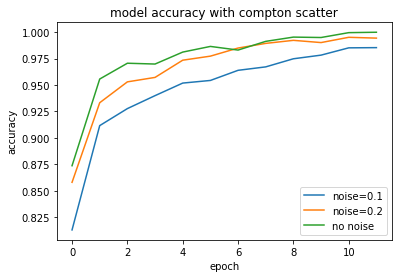

In [52]:
# Summarize the accuracy history
plt.plot(fit_cs_01.history['accuracy'])
plt.plot(fit_cs_02.history['accuracy'])
plt.plot(fit.history['accuracy'])
plt.title('model accuracy with compton scatter')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['noise=0.1', 'noise=0.2', 'no noise'], loc='bottom right')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


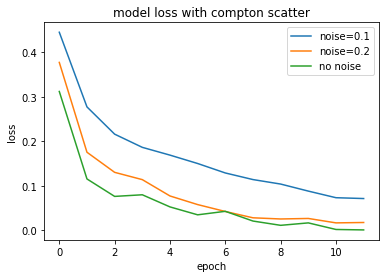

In [53]:
# Summarize the accuracy history
plt.plot(fit_cs_01.history['loss'])
plt.plot(fit_cs_02.history['loss'])
plt.plot(fit.history['loss'])
plt.title('model loss with compton scatter')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['noise=0.1', 'noise=0.2', 'no noise'], loc='bottom right')
plt.show()

### Edit exposure time

In [12]:
def edit_exposure(images, exp):
  ans = []
  for im in images:
    im *= exp
    ans.append(im)
  return tf.cast(ans, tf.float32)

In [13]:
# Exposure of 2x
x_train_ex_13 = edit_exposure(x_train, 1.3)  
x_test_ex_13 = edit_exposure(x_test, 1.3)
# Exposure of 0.5
x_train_ex_05 = edit_exposure(x_train, 0.5) 
x_test_ex_05 = edit_exposure(x_test, 0.5)

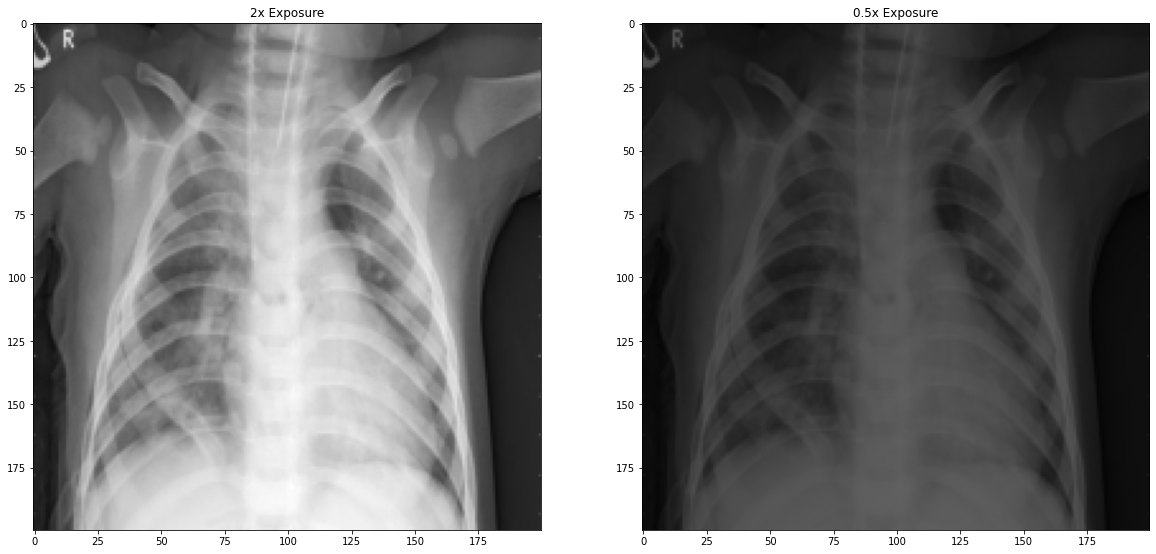

In [15]:
# Display sample images
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(x_train_ex_13[0])
plt.title(f'2x Exposure')
plt.subplot(1,2,2)
plt.imshow(x_train_ex_05[0])
plt.title(f'0.5x Exposure')
plt.show()

In [30]:
# Define a sequential model
model = tf.keras.models.Sequential([    
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # length-8 output for classification
])

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
fit_ex_13 = model.fit(x=x_train_ex_13, y=y_train, epochs=12, validation_data=(x_test_ex_13, y_test))

Epoch 1/12
163/163 [==============================] - 4s 24ms/step - loss: 0.3532 - accuracy: 0.8742 - val_loss: 0.7635 - val_accuracy: 0.7596
Epoch 2/12
163/163 [==============================] - 4s 23ms/step - loss: 0.1472 - accuracy: 0.9465 - val_loss: 0.9294 - val_accuracy: 0.7660
Epoch 3/12
163/163 [==============================] - 4s 23ms/step - loss: 0.1306 - accuracy: 0.9536 - val_loss: 1.3209 - val_accuracy: 0.7228
Epoch 4/12
163/163 [==============================] - 4s 23ms/step - loss: 0.1053 - accuracy: 0.9630 - val_loss: 1.1661 - val_accuracy: 0.7644
Epoch 5/12
163/163 [==============================] - 4s 23ms/step - loss: 0.0871 - accuracy: 0.9709 - val_loss: 1.9364 - val_accuracy: 0.7035
Epoch 6/12
163/163 [==============================] - 4s 23ms/step - loss: 0.0709 - accuracy: 0.9760 - val_loss: 1.2426 - val_accuracy: 0.7580
Epoch 7/12
163/163 [==============================] - 4s 23ms/step - loss: 0.0549 - accuracy: 0.9772 - val_loss: 1.4790 - val_accuracy: 0.7644

In [33]:
# Define a sequential model
model = tf.keras.models.Sequential([    
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # length-8 output for classification
])

In [34]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
fit_ex_05 = model.fit(x=x_train_ex_05, y=y_train, epochs=12, validation_data=(x_test_ex_05, y_test))

Epoch 1/12
163/163 [==============================] - 4s 24ms/step - loss: 0.2549 - accuracy: 0.8974 - val_loss: 1.0114 - val_accuracy: 0.7692
Epoch 2/12
163/163 [==============================] - 4s 23ms/step - loss: 0.1244 - accuracy: 0.9557 - val_loss: 1.0639 - val_accuracy: 0.7035
Epoch 3/12
163/163 [==============================] - 4s 23ms/step - loss: 0.1051 - accuracy: 0.9636 - val_loss: 1.4493 - val_accuracy: 0.6795
Epoch 4/12
163/163 [==============================] - 4s 23ms/step - loss: 0.0773 - accuracy: 0.9720 - val_loss: 1.1362 - val_accuracy: 0.7756
Epoch 5/12
163/163 [==============================] - 4s 23ms/step - loss: 0.0608 - accuracy: 0.9766 - val_loss: 1.3454 - val_accuracy: 0.7532
Epoch 6/12
163/163 [==============================] - 4s 23ms/step - loss: 0.0632 - accuracy: 0.9772 - val_loss: 1.6405 - val_accuracy: 0.7372
Epoch 7/12
163/163 [==============================] - 4s 23ms/step - loss: 0.0610 - accuracy: 0.9799 - val_loss: 1.4640 - val_accuracy: 0.7179

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


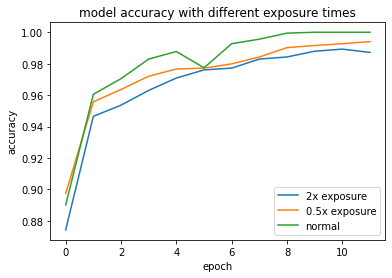

In [36]:
# Summarize the accuracy history
plt.plot(fit_ex_13.history['accuracy'])
plt.plot(fit_ex_05.history['accuracy'])
plt.plot(fit.history['accuracy'])
plt.title('model accuracy with different exposure times')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['2x exposure', '0.5x exposure', 'normal'], loc='bottom right')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


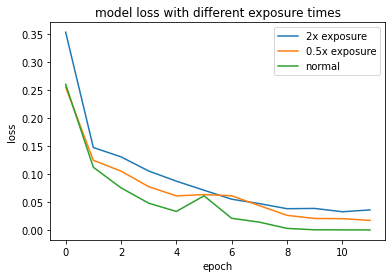

In [37]:
# Summarize the loss history
plt.plot(fit_ex_13.history['loss'])
plt.plot(fit_ex_05.history['loss'])
plt.plot(fit.history['loss'])
plt.title('model loss with different exposure times')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['2x exposure', '0.5x exposure', 'normal'], loc='bottom right')
plt.show()

# Define Tensorflow Eager Model

I never got this to work however I have no clue why... I spent days on this when I know I should have asked for help. Due to other finals/projects however I never had time and thus I have my final project that isn't as exciting as I hoped.

### Add the physical parameters

### Add exposure time

In [118]:
phase = np.ones((200,200,3)) * 1
exposure_phase = tf.Variable(initial_value=phase, dtype=tf.float32, trainable=True, name='exposurephase')

### Add a circular collameter

In [124]:
def collameter_mask():
  radius = 75
  center = (100,100)
  mask = np.zeros((200,200))
  for i in range(200):
    for j in range(200):
      if np.sqrt((i - center[0])**2 + (j-center[1])**2) <= radius:
        mask[i][j] = 1
  return mask  

collameter = collameter_mask()

collameter = collameter[..., tf.newaxis]

phase = np.ones((200,200,3))
collameter_phase = tf.Variable(initial_value=phase, dtype=tf.float32, trainable=True, name='collameterphase')

### Add compton scatter

In [121]:
# noise_phase = tf.random.normal(shape=(200,200,3), mean=0.0, stddev=0.1) * 1
# compton_scatter_phase = tf.Variable(initial_value=noise_phase, dtype=tf.float32, trainable=True, name='csphase')

### Apply Physical Layer

In [147]:
def physical_layer(img):

  im = tf.cast(img, tf.complex64)
  image = tf.exp(1j*im) 
  
  ex = tf.cast(exposure_phase, tf.complex64)
  exposure_p = tf.exp(1j*ex)
  ans = []
  for x in image:
    x = x[:,:,:,0]
    x = tf.math.multiply(exposure_p, x)
  
    x = tf.signal.fftshift(tf.signal.fft2d(x))

    aper = tf.cast(collameter_phase, tf.complex64)
    aperture = tf.exp(1j*aper)
    c = tf.math.multiply(collameter, aperture)
    tf.cast(c, tf.complex64)
    x = tf.math.multiply(x, c)

    x = tf.signal.ifft2d(tf.signal.ifftshift(x))
    x = tf.math.multiply(tf.math.abs(x), tf.math.abs(x)) 
  
    # cs = tf.cast(compton_scatter_phase, tf.complex64)
    # cs_phase = tf.exp(1j*cs)
    x += tf.random.normal(shape=(200,200,3), mean=0.0, stddev=0.1)
  
    ans.append(x)

  return tf.cast(ans, tf.float32) - 1



In [148]:
class CNN(tf.keras.Model):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu') 
    self.conv2 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=(2,2), padding='same', activation='relu')
    self.conv3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu') 
    self.conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same', activation='relu')
    self.flatten = tf.keras.layers.Flatten()
    self.drop = tf.keras.layers.Dropout(0.5)
    self.dense_1 = tf.keras.layers.Dense(units=32, activation='relu')
    self.dense_2 = tf.keras.layers.Dense(1, activation='sigmoid')   

  def call(self, x):
    conv = self.conv2(self.conv1(x))
    conv = self.conv4(self.conv3(conv))
    return self.dense_2(self.drop(self.dense_1(self.flatten(conv))))

model = CNN()

In [149]:
# the full forward model, which includes both the physical layer and the CNN model:
def forward_model(x_batch):
  p_layer_out = physical_layer(x_batch)
  return model(p_layer_out)

In [150]:
# train loop
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

num_epochs=20

# make train and test loss and accuracy trackers
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

In [151]:
# Training Function
def train_model(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)   # Change this to include the physical layer
    loss = loss_fn(labels, predictions)
  trainable_variables = model.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [152]:
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_fn(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [153]:
# The accuracy is always the same and the model does not train
for i in range(num_epochs):
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()
  for images, labels in train_ds:
    images = images[..., tf.newaxis]
    # labels = labels[..., tf.newaxis]
    train_model(images, labels)
  for images, labels in test_ds:
    images = images[..., tf.newaxis]
    # labels = labels[..., tf.newaxis]
    test_step(images, labels)
  print(
    f'Epoch {i + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 0.3112947940826416, Accuracy: 89.20629119873047, Test Loss: 0.4557133615016937, Test Accuracy: 85.15625
Epoch 2, Loss: 0.09794208407402039, Accuracy: 96.35736083984375, Test Loss: 1.059370756149292, Test Accuracy: 77.5
Epoch 3, Loss: 0.07599978148937225, Accuracy: 97.37346649169922, Test Loss: 1.3145376443862915, Test Accuracy: 71.09375
Epoch 4, Loss: 0.060605164617300034, Accuracy: 97.87193298339844, Test Loss: 1.1727579832077026, Test Accuracy: 75.9375
Epoch 5, Loss: 0.04200223460793495, Accuracy: 98.46626281738281, Test Loss: 2.084984540939331, Test Accuracy: 70.15625
Epoch 6, Loss: 0.016887832432985306, Accuracy: 99.55905151367188, Test Loss: 1.632311224937439, Test Accuracy: 75.15625
Epoch 7, Loss: 0.01674637570977211, Accuracy: 99.34815979003906, Test Loss: 1.508846640586853, Test Accuracy: 77.65625
Epoch 8, Loss: 0.008248630911111832, Accuracy: 99.80828094482422, Test Loss: 1.6057775020599365, Test Accuracy: 77.1875
Epoch 9, Loss: 0.00487369392067194, Accuracy: 99